In [1]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow h5py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


# INFO
This notebook is a reconstuction of the variance model using tensorflow library to achieve similar result achieved in sklearn and the original paper.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

## Dataset

In [3]:
fp = "../data/features_combined.csv"
batch_pd = pd.read_csv(fp, index_col=False)
dataset = batch_pd.copy()

In [4]:
dataset.isna().sum()
dataset = dataset.dropna().drop(columns=['policy', 'barcode'])
dataset

,cycle_life,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,QDiffLinVar
0,1189.0,1.070689,0.468365,1.075913,-2.072648,-2.541602,-5.014861,-0.274041,0.129790,-4.261444,-0.000210,1.091262,0.000039,1.072078,-5.013791
1,1178.0,1.075301,0.009288,1.080630,-1.958457,-2.387257,-5.013960,-0.367163,0.012464,-3.803325,0.000006,1.080945,-0.000041,1.084710,-5.017121
2,1176.0,1.079922,0.008131,1.084940,-1.764058,-2.348070,-4.737000,0.033502,-0.457627,-5.056484,0.000011,1.084826,-0.000044,1.089331,-4.734378
3,1225.0,1.079723,0.006530,1.084750,-1.722149,-2.127507,-4.442613,-0.357486,0.039579,-3.739833,0.000018,1.084053,-0.000003,1.085031,-4.438865
4,1226.0,1.078417,0.005900,1.082646,-1.855177,-2.240332,-4.647744,-0.440634,0.125101,-4.380559,0.000020,1.081850,-0.000033,1.085851,-4.642574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,462.0,1.073565,0.007075,1.079078,-1.226029,-1.547619,-3.394968,-1.993884,0.134112,-4.417652,0.000013,1.078951,-0.000031,1.082138,-3.391890
76,457.0,1.070887,0.006366,1.076360,-1.244632,-1.577172,-3.452581,-1.389835,0.111612,-4.012170,0.000023,1.075190,-0.000017,1.078153,-3.453071
77,487.0,1.070473,0.005186,1.073041,-1.361351,-1.680775,-3.688418,-1.539699,0.113010,-4.279524,-0.000006,1.074844,-0.000079,1.080819,-3.691468
78,429.0,1.072614,0.007384,1.079520,-1.219913,-1.521692,-3.368943,-1.205534,0.132095,-4.142284,0.000030,1.077609,-0.000013,1.080783,-3.369759


## Split Train-Test

In [5]:
train_dataset = dataset.iloc[0::2, :]
test_dataset = dataset.iloc[1::2, :]

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycle_life,40.0,661.900000,253.542370,148.000000,480.750000,566.500000,855.000000,1226.000000
QD2,40.0,1.074524,0.007838,1.048037,1.070504,1.074543,1.079108,1.094639
QD(Max-2),40.0,0.062221,0.293979,0.001546,0.004442,0.005628,0.006416,1.817914
QD100,40.0,1.073757,0.020363,0.968339,1.073190,1.077058,1.082280,1.095349
QDiffMin,40.0,-1.367683,0.210507,-2.072648,-1.436441,-1.336577,-1.242969,-0.860038
QDiffMean,40.0,-1.716718,0.254903,-2.541602,-1.799940,-1.683338,-1.600772,-1.109668
QDiffVar,40.0,-3.704868,0.424797,-5.014861,-3.842137,-3.627437,-3.480982,-2.726901
QDiffSkew,40.0,-0.797872,0.372961,-1.500458,-1.066717,-0.848007,-0.534206,0.033502
QDiffKurtosis,40.0,0.076688,0.109324,-0.457627,0.090105,0.103363,0.116203,0.132095
QDiffStart,40.0,-4.236484,0.498418,-5.440747,-4.540804,-4.182197,-3.829733,-3.523679


In [7]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('cycle_life')
test_labels = test_features.pop('cycle_life')

## Normalization Layer

In [8]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 1.0745237e+00  6.2220503e-02  1.0737574e+00 -1.3676827e+00
  -1.7167178e+00 -3.7048676e+00 -7.9787225e-01  7.6688468e-02
  -4.2364841e+00 -5.2411451e-05  1.0802388e+00 -9.6687763e-05
   1.0834242e+00 -3.7046471e+00]]


2022-07-23 15:03:53.895122: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Linear Regression Model Building

### Layering

In [9]:
QDiffLinVar = np.array(train_features['QDiffLinVar'])

QDiffLinVar_normalizer = layers.Normalization(input_shape=[1,], axis=None)
QDiffLinVar_normalizer.adapt(QDiffLinVar)

### Build the model and compile

In [34]:
variance_model = tf.keras.Sequential([
    QDiffLinVar_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear'),
])

variance_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
    )

variance_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 196
Trainable params: 193
Non-trainable params: 3
_________________________________________________________________


### Model Training

In [15]:
%%time
history = variance_model.fit(
    train_features['QDiffLinVar'],
    train_labels,
    epochs=2500,
    verbose=2, # verbose=0 for silent
    validation_data = (test_features['QDiffLinVar'], test_labels)) # validate against the test set.

Epoch 1/2500
2/2 - 1s - loss: 500887.0000 - mae: 661.9855 - val_loss: 477738.2500 - val_mae: 655.0039 - 591ms/epoch - 296ms/step
Epoch 2/2500
2/2 - 0s - loss: 500854.8125 - mae: 661.9589 - val_loss: 477708.3125 - val_mae: 654.9792 - 22ms/epoch - 11ms/step
Epoch 3/2500
2/2 - 0s - loss: 500823.9062 - mae: 661.9332 - val_loss: 477678.5625 - val_mae: 654.9546 - 24ms/epoch - 12ms/step
Epoch 4/2500
2/2 - 0s - loss: 500791.9062 - mae: 661.9069 - val_loss: 477649.0938 - val_mae: 654.9304 - 24ms/epoch - 12ms/step
Epoch 5/2500
2/2 - 0s - loss: 500761.3125 - mae: 661.8809 - val_loss: 477619.6875 - val_mae: 654.9064 - 30ms/epoch - 15ms/step
Epoch 6/2500
2/2 - 0s - loss: 500730.0000 - mae: 661.8554 - val_loss: 477590.0000 - val_mae: 654.8823 - 34ms/epoch - 17ms/step
Epoch 7/2500
2/2 - 0s - loss: 500699.0938 - mae: 661.8300 - val_loss: 477560.3125 - val_mae: 654.8580 - 31ms/epoch - 15ms/step
Epoch 8/2500
2/2 - 0s - loss: 500667.7500 - mae: 661.8038 - val_loss: 477530.7500 - val_mae: 654.8339 - 40ms/

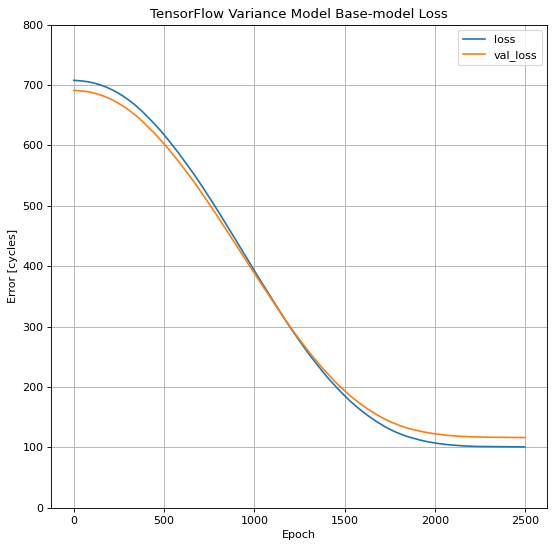

In [16]:
def plot_loss(history):
  plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(np.sqrt(history.history['loss']), label='loss')
  plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
  plt.ylim([0, 800])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cycles]')
  plt.legend()
  plt.title('TensorFlow Variance Model Base-model Loss')
  plt.grid(True)
  plt.savefig('../variance_model/figures/variance_model_tensorflow_loss.png')

plot_loss(history)

In [17]:
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist


,loss,mae,val_loss,val_mae,epoch
0,707.733707,25.729078,691.186118,25.593044,0
1,707.710967,25.728561,691.164461,25.592561,1
2,707.689131,25.728062,691.142939,25.592081,2
3,707.666522,25.727551,691.121620,25.591608,3
4,707.644906,25.727045,691.100345,25.591140,4
...,...,...,...,...,...
2495,100.772514,9.006853,116.330307,10.183405,2495
2496,100.769747,9.006552,116.335238,10.183455,2496
2497,100.768502,9.006583,116.339876,10.183518,2497
2498,100.761917,9.005915,116.344359,10.183598,2498


### Predict

In [30]:
def plot_prediction(y_train, y_test):
  plt.figure(figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
  plt.axes(aspect='equal')
  plt.scatter(y_train, train_labels, label='Predictions (train)')
  plt.scatter(y_test, test_labels, label='Predictions (test)', marker='^')
  lims = [0, 2000]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims, 'k', )
  plt.xlabel('Predicted Cycle life')
  plt.ylabel('Actual Cycle life')
  plt.title('TensorFlow Variance Model Base-model Prediction')
  plt.legend()
  plt.savefig('../variance_model/figures/variance_model_tensorflow_prediction.png')

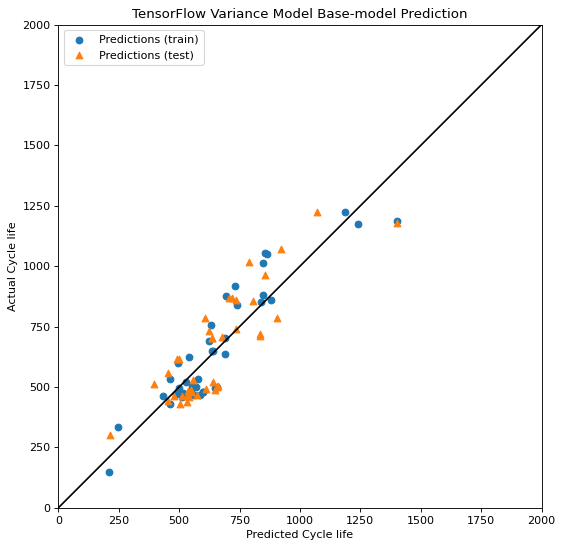

In [33]:
train_prediction = variance_model.predict(train_features['QDiffLinVar'])
test_prediction = variance_model.predict(test_features['QDiffLinVar'])
plot_prediction(train_prediction, test_prediction)

### Evaluate

In [18]:
test_results = {}

test_results['variance_model'] = variance_model.evaluate(
    test_features['QDiffLinVar'],
    test_labels, verbose=0) #sqrt for mse

In [22]:
test_results['variance_model'][0] = test_results['variance_model'][0] ** 0.5
pd.DataFrame(test_results, index=['MSE', 'Mean absolute error']).T

,MSE,Mean absolute error
variance_model,116.349588,103.70742


### Error Distribution

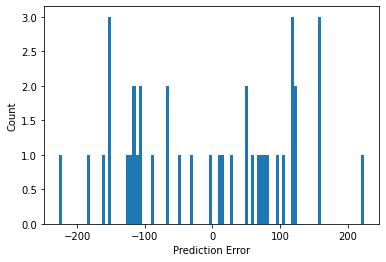

In [23]:
error = test_prediction.flatten() - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')